In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,GRU, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import string



nltk.download('stopwords')
nltk.download('punkt')

np.random.seed(2)


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


### EDA 

Here I performed exploratory data analysis (EDA) on the training dataset to gain insights into its structure and content. The code begins with printing the shape of the dataset to understand the number of rows and columns. 

A pie chart is created to show the composition of positive (target=1) and negative (target=0) labels, helping to assess the class balance. 

The text data is then cleaned by removing URLs, special characters, and stopwords, followed by tokenization. 
Using this processed data, the top 20 most common words are identified and visualized for both positive and negative tweets through bar plots. 

Additionally, the lengths of the tweets (number of words) are calculated and plotted as a histogram to examine the distribution of text lengths. 

Finally, the code analyzes the location field by identifying the top 20 most frequent locations mentioned in the tweets and visualizes them using a bar plot. 

These steps collectively provide insights into the dataset's structure, text patterns, and geographical information.

Shape of Training Data


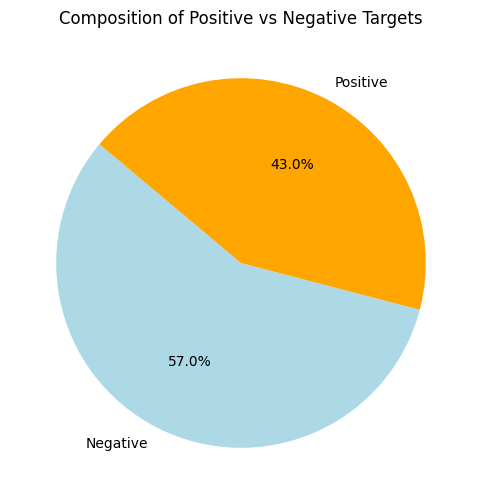

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


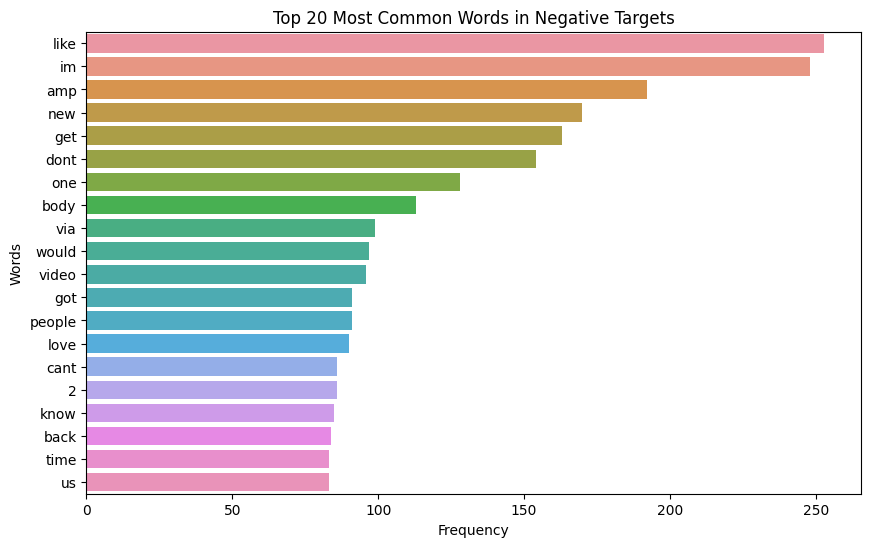

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


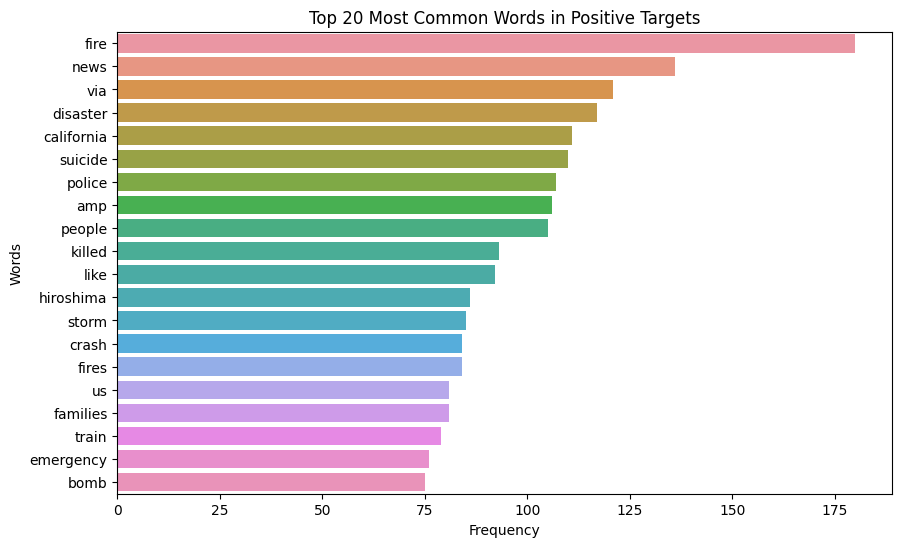

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


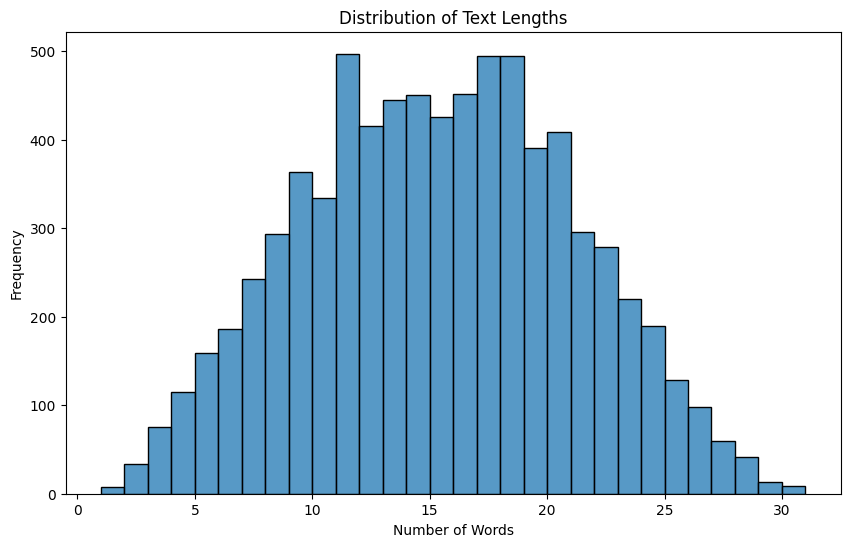

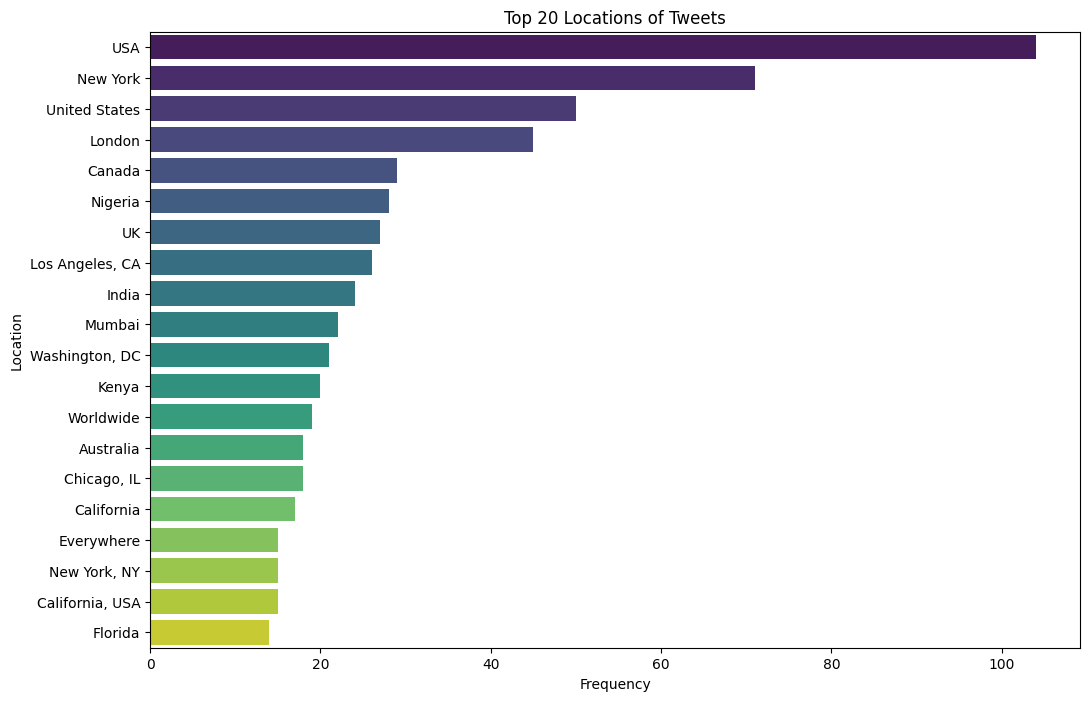

In [8]:

df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Shape of Training Data')

target_counts = df_train['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    target_counts,
    labels=["Negative", "Positive"],
    autopct='%1.1f%%',
    startangle=140,
    colors=['lightblue', 'orange']
)
plt.title("Composition of Positive vs Negative Targets")
plt.show()

# Preprocess text for token analysis
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Remove stopwords
stop_words = set(stopwords.words('english'))
def tokenize_and_filter(text):
    tokens = word_tokenize(clean_text(text))
    return [word for word in tokens if word not in stop_words]


positive_tokens = [token for text in df_train[df_train['target'] == 1]['text'] for token in tokenize_and_filter(text)]
negative_tokens = [token for text in df_train[df_train['target'] == 0]['text'] for token in tokenize_and_filter(text)]

# 20 most common words in negative targets
negative_word_counts = Counter(negative_tokens).most_common(20)
negative_words, negative_freqs = zip(*negative_word_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(negative_freqs), y=list(negative_words))
plt.title("Top 20 Most Common Words in Negative Targets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# 20 most common words in positive targets
positive_word_counts = Counter(positive_tokens).most_common(20)
positive_words, positive_freqs = zip(*positive_word_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(positive_freqs), y=list(positive_words))
plt.title("Top 20 Most Common Words in Positive Targets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# text lengths
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# location
location_counts = df_train['location'].value_counts().head(20)  # Top 20 locations
plt.figure(figsize=(12, 8))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')
plt.title("Top 20 Locations of Tweets")
plt.xlabel("Frequency")
plt.ylabel("Location")
plt.show()

### DATA PREPROCESSING

I prprocessed the data to prepare it for training with RNN, GRU, and LSTM models by cleaning, tokenizing, and padding the text.

I began with text cleaning, where three functions are applied to remove unwanted elements from the text. URLs are removed using the remove_url function, punctuation is stripped away with the remove_punctuation function, and common stopwords are eliminated using the remove_stopwords function, which also tokenizes the text and converts it to lowercase. These steps ensure that the text is simplified and not accounting for unnecessary information that would not be useful for modeling.

Next, the Tokenizer from Keras is used to convert the cleaned text into sequences of integers, where each integer represents a word in the vocabulary. The tokenizer is fit on the training data to build a word index, ensuring that the vocabulary matches the training set. Once tokenized, the text sequences are padded and truncated to a fixed length (max_len=30) using the pad_sequences function. This step ensures that all sequences have uniform lengths, which is required for feeding data into neural network models.

Finally, I assign the target column from the training data as y, representing the labels for supervised learning. The resulting X_train_padded and X_test_padded datasets, along with y, are now ready for use in RNN, GRU, and LSTM models.

In [9]:
# Preprocessing functions
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    return " ".join([word for word in tokens if word not in stop_words])

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

stop_words = set(stopwords.words('english'))

# Clean the text
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

df_train['text'] = df_train['text'].apply(remove_url)
df_train['text'] = df_train['text'].apply(remove_punctuation)

df_test['text'] = df_test['text'].apply(remove_url)
df_test['text'] = df_test['text'].apply(remove_punctuation)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])

X_train_sequences = tokenizer.texts_to_sequences(df_train['text'])
X_test_sequences = tokenizer.texts_to_sequences(df_test['text'])

max_len = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

y = df_train['target']


After processing, I split the training dataset into X and Y values. These were assigned as training and validation data. The Validation was 20% of the data set. The training data was 80% of the training data.

In [10]:
# Train-test split
X_train, X_validation, y_train, y_validation = train_test_split(X_train_padded, y, test_size=0.2, random_state=42)

word_index = tokenizer.word_index



### RNN Model

I chose the Simple RNN as a baseline model because it is the simplest form of recurrent neural networks designed to handle sequential data. For the architecture, I used an embedding layer to learn word representations, followed by a SimpleRNN layer with 100 units to process sequential dependencies, and a dense output layer with a sigmoid activation for binary classification. While Simple RNNs are less powerful compared to GRUs or LSTMs, they are computationally efficient and provide a good starting point for comparison.

In [11]:
# Simple RNN Model
model = Sequential([Embedding(input_dim=len(word_index) + 1, output_dim=300, name="Embedding_Layer"),
    SimpleRNN(100, name="SimpleRNN_Layer"),
    Dense(1, activation='sigmoid', name="Output_Layer")])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.build(input_shape=(None, max_len))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ (None, 30, 300)        │     6,707,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,747,601 (25.74 MB)

 Trainable params: 6,747,601 (25.74 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6431 - loss: 0.6344 - val_accuracy: 0.7078 - val_loss: 0.6031
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8379 - loss: 0.4130 - val_accuracy: 0.7531 - val_loss: 0.5554
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9268 - loss: 0.2096 - val_accuracy: 0.6980 - val_loss: 0.7339
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9802 - loss: 0.0615 - val_accuracy: 0.7269 - val_loss: 0.8233
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9795 - loss: 0.0624 - val_accuracy: 0.7183 - val_loss: 0.9969
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6788 - loss: 1.0809
Validation Loss: 0.9969, Validation Accuracy: 0.7183


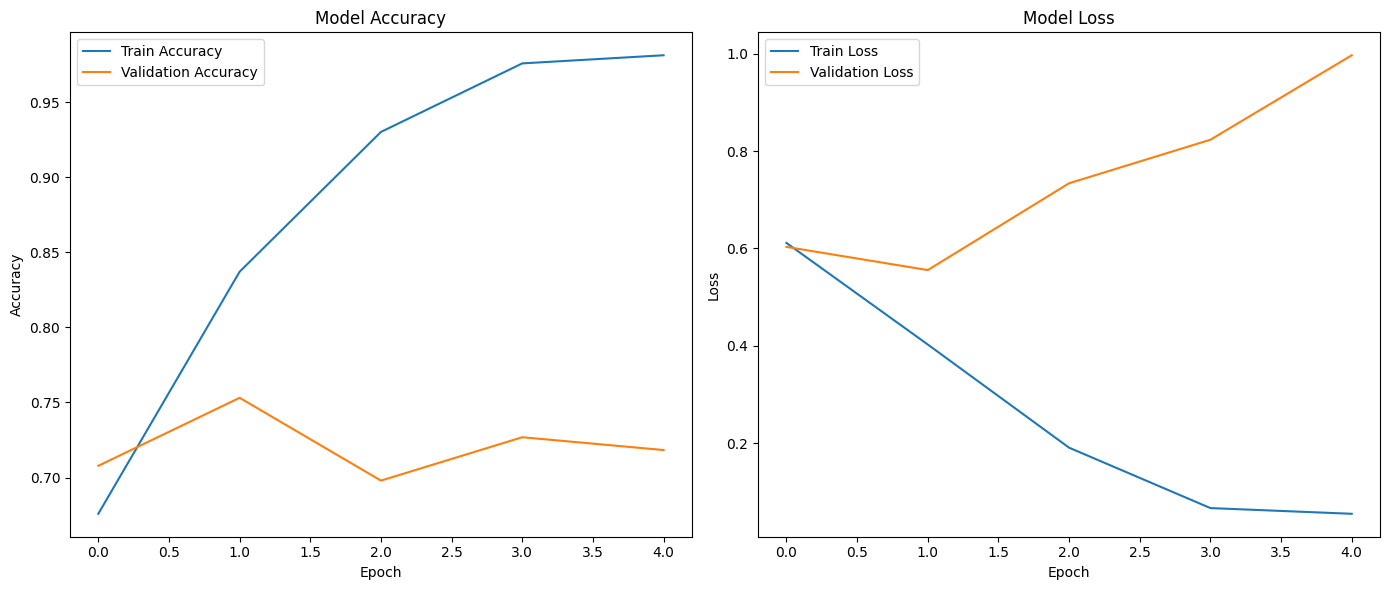

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=5, batch_size=32)

val_loss, val_accuracy = model.evaluate(X_validation, y_validation)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(14, 6))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### GRU Model

I selected the GRU model because it is more efficient and better at handling longer-term dependencies than Simple RNNs. The architecture includes an embedding layer for word representation, a GRU layer with 100 units to capture temporal patterns, and a dense output layer with a sigmoid activation. GRUs are less complex than LSTMs but still address the vanishing gradient problem, making them a practical choice for capturing patterns in sequential text data while maintaining faster training times.

In [13]:
# GRU model
gru_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=300, name="Embedding_Layer"),
    GRU(100, name="GRU_Layer"),  
    Dense(1, activation='sigmoid', name="Output_Layer")])

# Compile
gru_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

gru_model.build(input_shape=(None, max_len))

print(gru_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ (None, 30, 300)        │     6,707,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_Layer (GRU)                 │ (None, 100)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,828,101 (26.05 MB)

 Trainable params: 6,828,101 (26.05 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9970 - loss: 0.0045 - val_accuracy: 0.7525 - val_loss: 1.1915
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9972 - loss: 0.0049 - val_accuracy: 0.7498 - val_loss: 1.1794
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9978 - loss: 0.0050 - val_accuracy: 0.7420 - val_loss: 1.2645
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9975 - loss: 0.0054 - val_accuracy: 0.7321 - val_loss: 1.3932
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9960 - loss: 0.0059 - val_accuracy: 0.7590 - val_loss: 1.0781
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9959 - loss: 0.0079 - val_accuracy: 0.7603 - val_loss: 1.3073
Epoch 7/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9974 - loss: 0.0052 - val_accuracy: 0.7518 - val_loss: 1.3661
Epoch 8/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9967 - loss: 0.0048 - val_accu

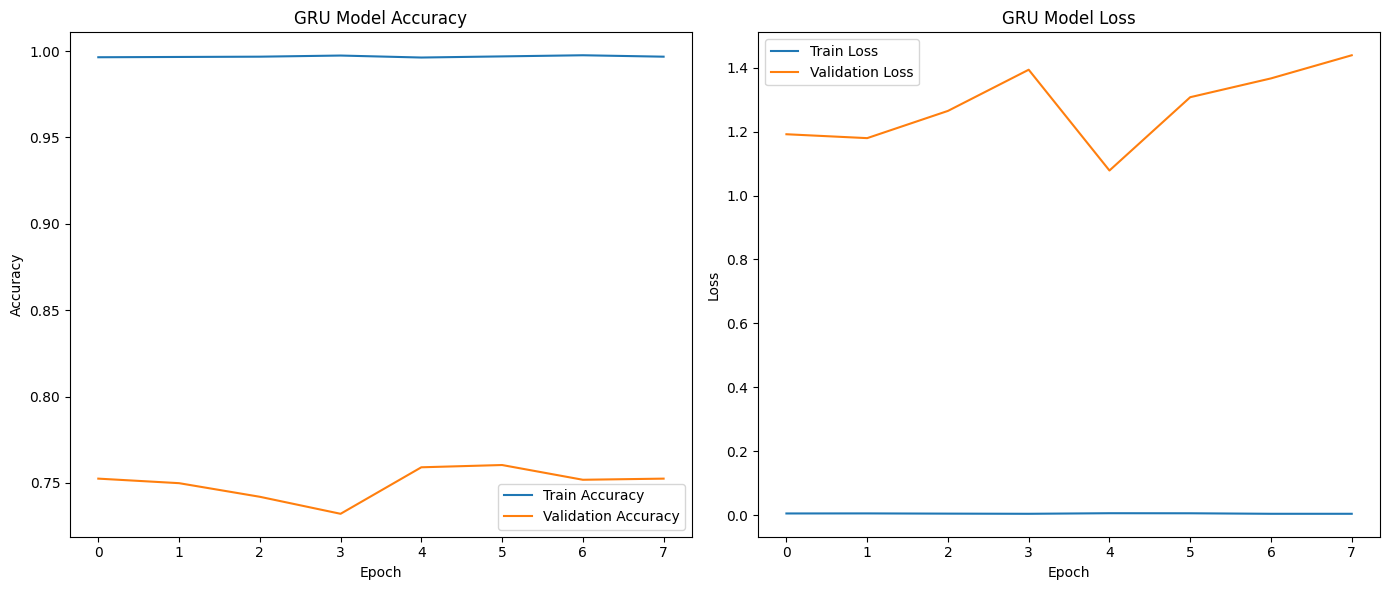

In [20]:
# Train GRU model
gru_history = gru_model.fit(X_train, y_train, 
    validation_data=(X_validation, y_validation), epochs=8, batch_size=32)

# Evaluate 
gru_val_loss, gru_val_accuracy = gru_model.evaluate(X_validation, y_validation)
print(f"GRU Validation Loss: {gru_val_loss:.4f}, Validation Accuracy: {gru_val_accuracy:.4f}")


plt.figure(figsize=(14, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### LSTM Model

I decided to use the LSTM model because of its strength in learning long-term dependencies in sequential data. Its architecture consists of an embedding layer, an LSTM layer with 100 units, and a dense output layer with a sigmoid activation. LSTMs use memory cells and gates to manage long-term information effectively while reducing the impact of vanishing gradients. This makes them particularly well-suited for datasets where understanding the long-range relationships between words is critical.

In [17]:
# LSTM Model
lstm_model = Sequential([Embedding(input_dim=len(word_index) + 1, output_dim=300, name="Embedding_Layer"),
    LSTM(100, name="LSTM_Layer"),  # LSTM replaces SimpleRNN
    Dense(1, activation='sigmoid', name="Output_Layer")])

# Compile
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


lstm_model.build(input_shape=(None, max_len))

print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ (None, 30, 300)        │     6,707,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,867,901 (26.20 MB)

 Trainable params: 6,867,901 (26.20 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9933 - loss: 0.0230 - val_accuracy: 0.7321 - val_loss: 1.0286
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9954 - loss: 0.0181 - val_accuracy: 0.7466 - val_loss: 1.1705
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9965 - loss: 0.0133 - val_accuracy: 0.7301 - val_loss: 1.4725
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9956 - loss: 0.0079 - val_accuracy: 0.7295 - val_loss: 1.8860
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.7557 - val_loss: 1.2150
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9958 - loss: 0.0092 - val_accuracy: 0.7590 - val_loss: 1.0114
Epoch 7/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9960 - loss: 0.0112 - val_accuracy: 0.7557 - val_loss: 0.9935
Epoch 8/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.9952 - loss: 0.0130 - val_accu

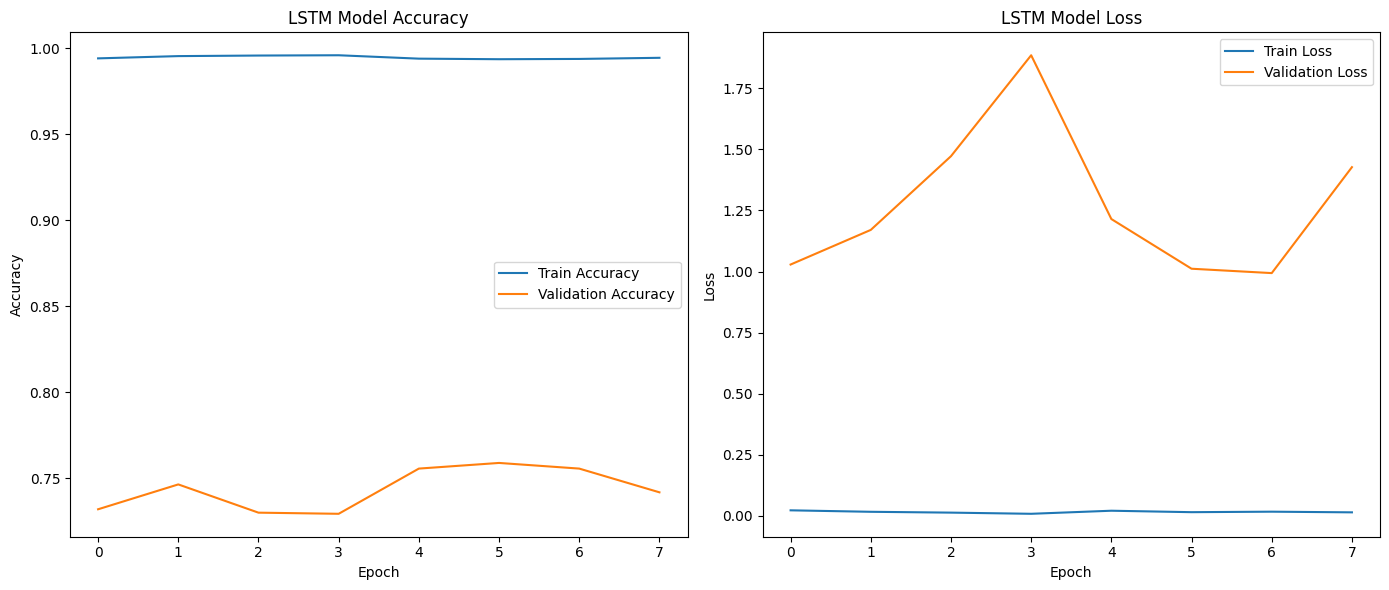

In [19]:
# LSTM model
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=8, batch_size=32)

# Evaluate 
lstm_val_loss, lstm_val_accuracy = lstm_model.evaluate(X_validation, y_validation)
print(f"LSTM Validation Loss: {lstm_val_loss:.4f}, Validation Accuracy: {lstm_val_accuracy:.4f}")


plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Comparisons

After testing the Simple RNN, GRU, and LSTM models, plots were created to test how well they handled validation data by looking at both their validation accuracy and loss.

The Simple RNN started with a validation accuracy of 70.78% and a validation loss of 0.6031 in the first epoch, but by the fifth epoch, its accuracy increased to 71.83% while the loss increased to 0.9969. This shows the model began overfitting and memorizing the training data instead of learning general patterns.

The GRU model performed the second best. It reached the highest validation accuracy of 75.57% with a validation loss of 1.2150 in the fifth epoch. Later dropped slightly to  and loss increased further, showing some overfitting but still handling new data better than the other models.

The LSTM model peaked at a validation accuracy of 75.9% in the 6th epoch with a validation loss of 1.0114, but by the 7th epoch, its accuracy dropped to 75.57% while the loss decreased to 0.9935. It overfit quickly and struggled more with generalizing to new data.

Out of the  three models trained, the LSTM model is the best overall by a small margin. It achieved the highest validation accuracy (75.9%) and maintained a reasonable validation loss, making it the most reliable model for handling new data. The LSTM at 6 epochs works best before it begins to overfit.

### Generating Model and CSV for Submission

As mentioned, the GRU model with 4 Epochs performed the best out of all of the models I created and tested. 
Therefore, it was used to create my submission for the Kaggle competition. 

As the model did not score as well as others in the Kaggle competition, it may be worth expanding to different model types in the future and assessing whether bi-directional models would work better. Examples of such models would be bidirectional LSTM and B-GRU. It would also be worth examining different methods to further embedd the words, to see if they would assist performance of the model. 

In [21]:
lstm_model = Sequential([Embedding(input_dim=len(word_index) + 1, output_dim=300, name="Embedding_Layer"),
    LSTM(100, name="LSTM_Layer"),Dense(1, activation='sigmoid', name="Output_Layer")])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
    epochs=6, batch_size=32)

lstm_predictions = lstm_model.predict(X_test_padded)

lstm_predictions_binary = (lstm_predictions > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': df_test['id'], 'target': lstm_predictions_binary})

submission.to_csv("submission_6_epochs.csv", index=False)

print(submission.head())

Epoch 1/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.6455 - loss: 0.6219 - val_accuracy: 0.7800 - val_loss: 0.4682
Epoch 2/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8880 - loss: 0.2916 - val_accuracy: 0.7971 - val_loss: 0.4821
Epoch 3/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9610 - loss: 0.1316 - val_accuracy: 0.7958 - val_loss: 0.5538
Epoch 4/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9720 - loss: 0.0821 - val_accuracy: 0.7689 - val_loss: 0.6703
Epoch 5/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9900 - loss: 0.0333 - val_accuracy: 0.7643 - val_loss: 1.1371
Epoch 6/6
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9903 - loss: 0.0368 - val_accuracy: 0.7571 - val_loss: 0.9672
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
   id  target
0   0       0
1   2       1
2   3       1
3   9       1
4  11       1
